# Brief XMM exploration of DES selected low-mass AGN candidates

Here I perform a very brief and basic analysis of 11 DES variability selected low-mass AGN candidates using XGA, running on the cleaned data and region files of the XMM Cluster Survey (XCS). The general goal is to find which candidates are detected in XMM, generate PSF corrected images, and measure **preliminary** basic spectral properties such as $L_\rm{X}$.

## Import Statements

In [1]:
from astropy.units import Quantity
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

from xga.samples import PointSample
from xga.xspec import power_law
from xga.imagetools.psf import rl_psf
from xga.products import Image
from xga.sas import emosaic, evselect_image
from xga import SAS_VERSION, XSPEC_VERSION

## Displaying Software Versions

In [2]:
print("XSPEC v{}".format(XSPEC_VERSION))
print("SAS v{}".format(SAS_VERSION))

XSPEC v12.10.1
SAS v17.0.0


## Reading in the sample file

This information is taken from Table 3 of the paper, and includes position, name, and redshift information.

In [3]:
sample = pd.read_csv("table_3_useful_info.csv")
sample

,name,ra,dec,zp,zs
0,J033150.63-282910.86,52.9610,-28.4863,1.02,NaN
1,J033129.06-272336.65,52.8711,-27.3935,0.36,0.3456
2,J033051.65-272856.18,52.7152,-27.4823,0.58,NaN
3,J032723.33-275657.10,51.8472,-27.9492,0.35,0.4635
4,J033240.53-283622.28,53.1689,-28.6062,0.31,0.3224
5,J032955.16-284359.67,52.4798,-28.7332,0.04,NaN
6,J032705.57-284011.91,51.7732,-28.6700,0.71,NaN
7,J003526.35-443806.37,8.8598,-44.6351,1.15,NaN
8,J003406.02-442101.84,8.5251,-44.3505,0.25,NaN
9,J022305.26-042800.90,35.7719,-4.4669,0.90,0.8194


## Selecting the redshift to use

Table 3 of the paper provides two sets of redshift information, one derived from photometric methods and one from spectroscopic. Not all of the candidates have spectroscopic redshifts, but we will use those values if they do. Uncertainties have not been included here, though some of the photometric redshifts have significant errors, that is because quantities such as $L_{\rm{X}}$ are not to be included in the current paper but are only for sanity checks.

In [4]:
chos_redshifts = sample['zs'].values.copy()
wh_nan = np.where(np.isnan(chos_redshifts))[0]
chos_redshifts[wh_nan] = sample['zp'][wh_nan]
chos_redshifts

array([1.02  , 0.3456, 0.58  , 0.4635, 0.3224, 0.04  , 0.71  , 1.15  ,
       0.25  , 0.8194, 0.0694])

## Defining an XGA PointSample

Here I define an XGA PointSample, which is designed for samples of generic point sources. The dedicated AGN class in XGA is still a work in progress, but PointSample will be sufficient for the very simple analyses here. Only the positions, names, and redshifts are required. Automatic PSF correction is set to `False` as we shall manually run it later with a greater-than-usual number of PSF bins.

We set `back_inn_rad_factor` and `back_out_rad_factor` to 2 and 3 respectively, meaning that background regions are generated between 2-3 times the spectrum generation region (in this case an aperture with a radius of 30 arcseconds).

In [5]:
srcs = PointSample(sample['ra'].values, sample['dec'].values, chos_redshifts, sample['name'].values, 
                   psf_corr=False, back_inn_rad_factor=2, back_out_rad_factor=3)

Setting up Point Sources:  82%|████████▏ | 9/11 [00:56<00:08,  4.34s/it]/home/dt237/code/PycharmProjects/XGA/xga/sources/base.py:1320: UserWarning: 2 matches for the point source J022305.26-042800.90 are found in the 0785101901 region file. The source nearest to the passed coordinates is accepted, all others will be placed in the alternate match category and will not be removed by masks.
  warnings.warn("{ns} matches for the point source {n} are found in the {o} region "
Setting up Point Sources: 100%|██████████| 11/11 [01:22<00:00,  7.51s/it]


## Displaying general information about the sources

Here we use XGA source's `info` method to display some basic information about the source with regards to XMM. We also use the `detected` property to assess how many of the sources have been detected in **at least one** XMM observation by the XCS source finder XAPA:

In [6]:
det = 0
for src in srcs:
    if any(src.detected.values()):
        det += 1
    src.info()


-----------------------------------------------------
Source Name - J033150.63-282910.86
User Coordinates - (52.961, -28.4863) degrees
X-ray Peak - (52.961, -28.4863) degrees
nH - 0.00779 1e+22 / cm2
Redshift - 1.02
XMM ObsIDs - 7
PN Observations - 1
MOS1 Observations - 4
MOS2 Observations - 7
On-Axis - 4
With regions - 7
Total regions - 275
Obs with one match - 0
Obs with >1 matches - 0
Images associated - 24
Exposure maps associated - 24
Combined Ratemaps associated - 1
Spectra associated - 0
-----------------------------------------------------


-----------------------------------------------------
Source Name - J033129.06-272336.65
User Coordinates - (52.8711, -27.3935) degrees
X-ray Peak - (52.8711, -27.3935) degrees
nH - 0.00733 1e+22 / cm2
Redshift - 0.346
XMM ObsIDs - 6
PN Observations - 3
MOS1 Observations - 3
MOS2 Observations - 5
On-Axis - 0
With regions - 6
Total regions - 378
Obs with one match - 2
Obs with >1 matches - 0
Images associated - 22
Exposure maps associated -

In [7]:
print("Of the {n} sources, {d} have been detected in at least one XMM observation by the XCS source "\
      "finder.".format(n=len(srcs), d=det))

Of the 11 sources, 6 have been detected in at least one XMM observation by the XCS source finder.


## Running PSF correction on the images

This calls the XGA Richardson-Lucy PSF correction, that takes into account the spatially varing XMM PSF, but with more PSF bins per side than is the default. Normally there are 4 bins which will result in an image being divided into 16 sections, this time there are 8 bins which means each image will be in 64 sections:

In [8]:
rl_psf(srcs, bins=8)

Generating products of type(s) image: 100%|██████████| 11/11 [00:03<00:00,  3.28it/s]


## Side-by-side comparisons of the combined ratemaps - original and PSF corrected

The PSF correction is run on individual images, but XGA automatically adds them together into a combined image and then divides through by the combined exposure map to create these combined RateMaps. This helps to account for the vignetting effects that are present in X-ray data. Information is printed to indicate whether a particular source is considered detected in XCS, and what redshift it is at. 

RateMaps shown are in the 0.5-2.0keV energy range, and apertures with a radius of 50 arcseconds are applied, interloper sources are **NOT** removed, the data are zoomed in. We overlay the XCS regions that are considered to be detections of each source, multiple regions indicate detection in multiple observations:

NOT DETECTED, REDSHIFT=1.02


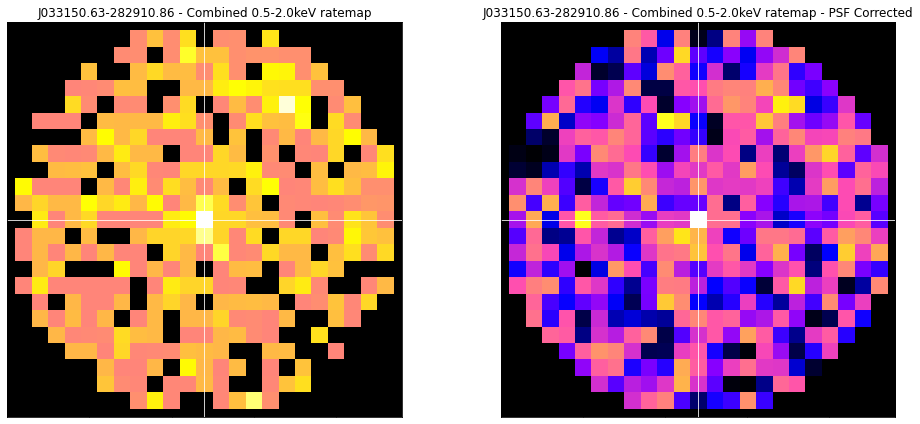

DETECTED, REDSHIFT=0.3456


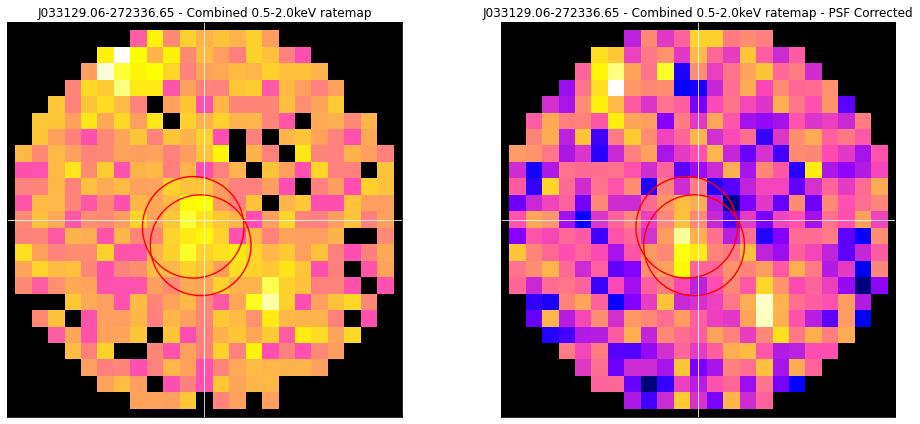

DETECTED, REDSHIFT=0.58


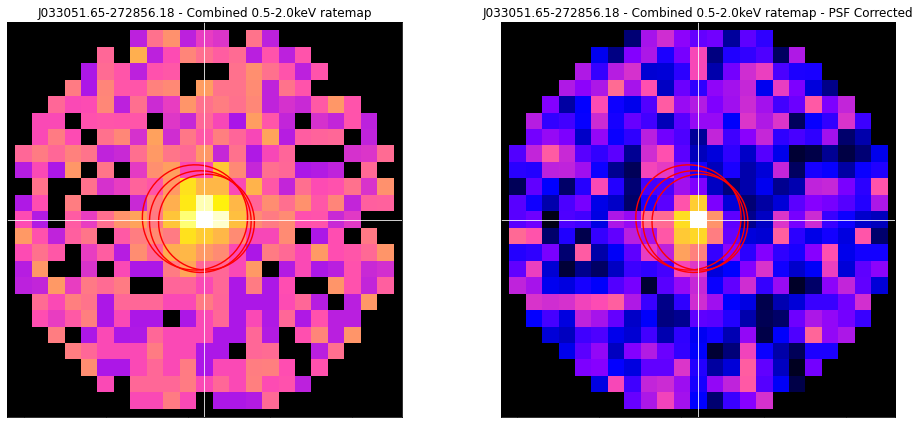

DETECTED, REDSHIFT=0.4635


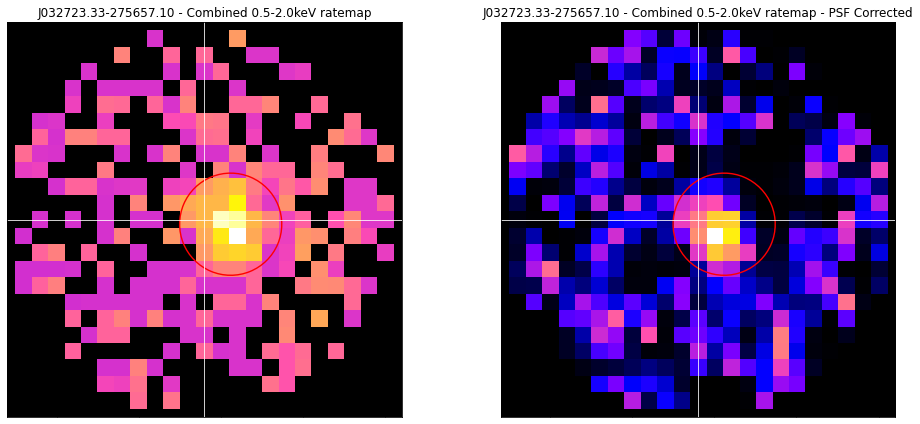

NOT DETECTED, REDSHIFT=0.3224


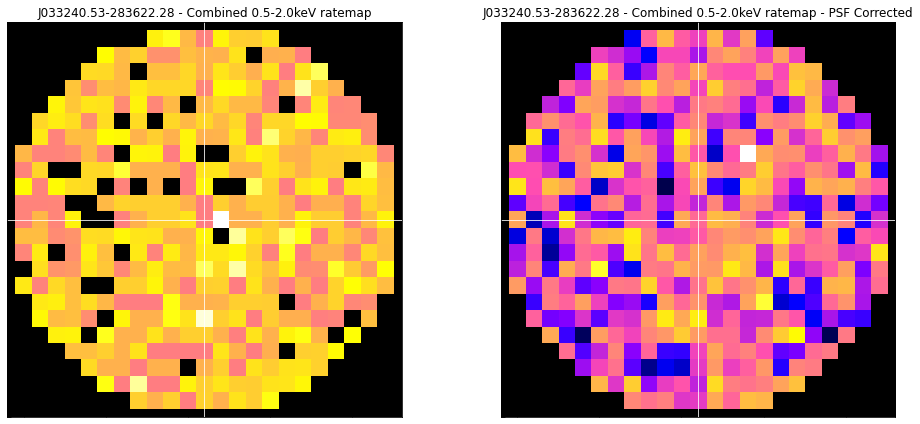

NOT DETECTED, REDSHIFT=0.04


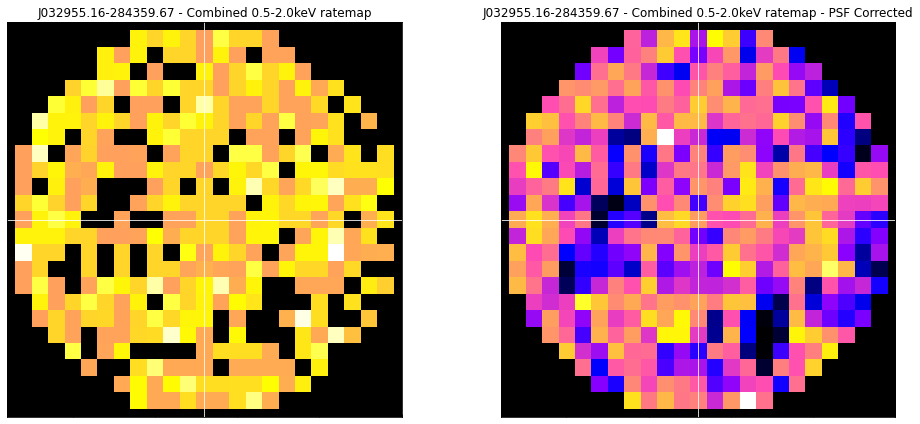

DETECTED, REDSHIFT=0.71


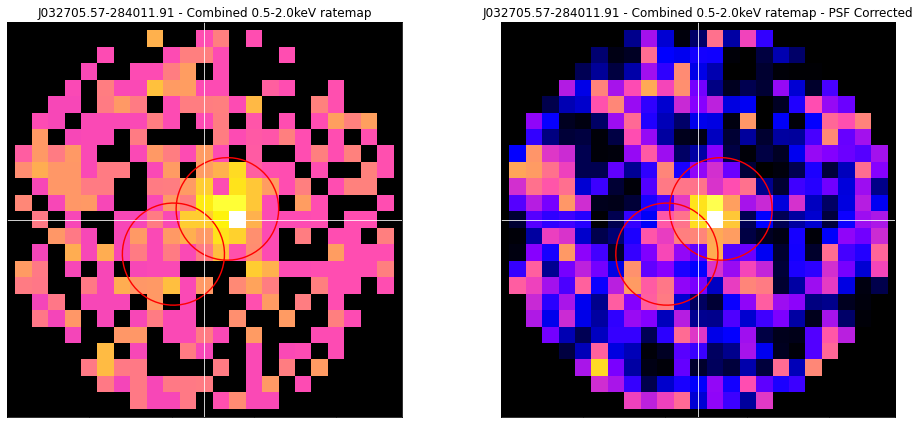

DETECTED, REDSHIFT=1.15


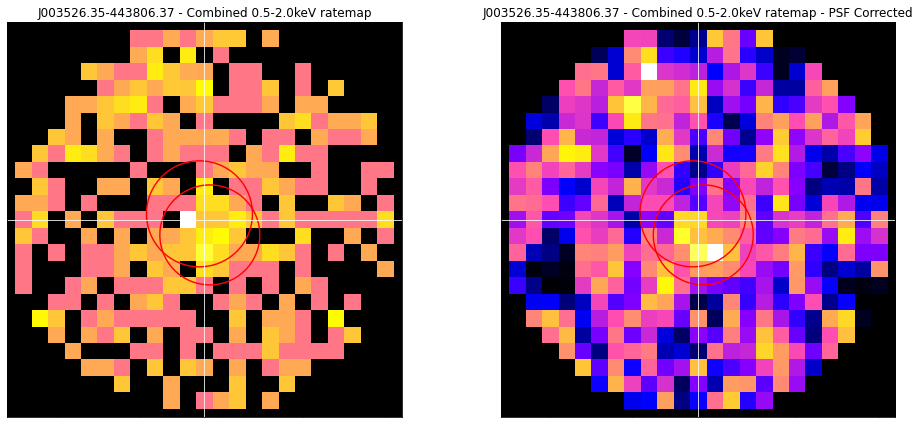

NOT DETECTED, REDSHIFT=0.25


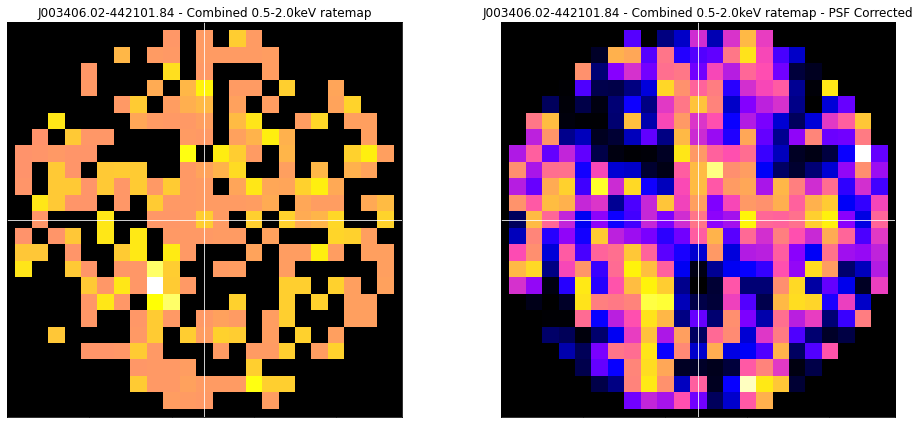

DETECTED, REDSHIFT=0.8194


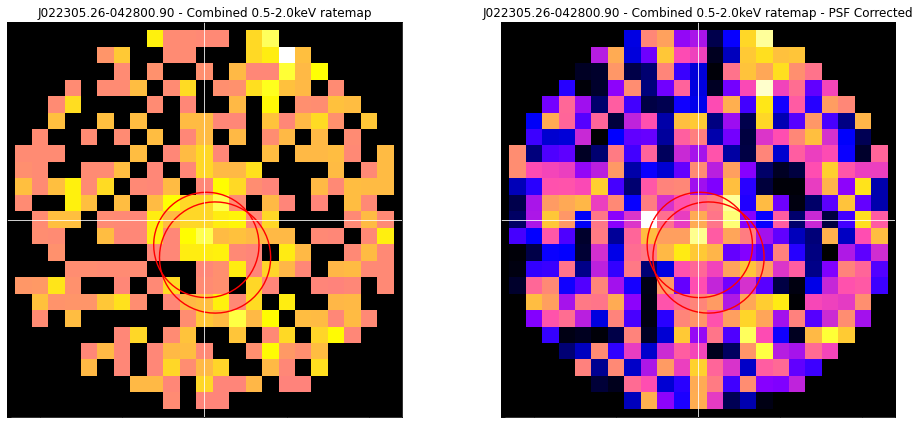

NOT DETECTED, REDSHIFT=0.0694


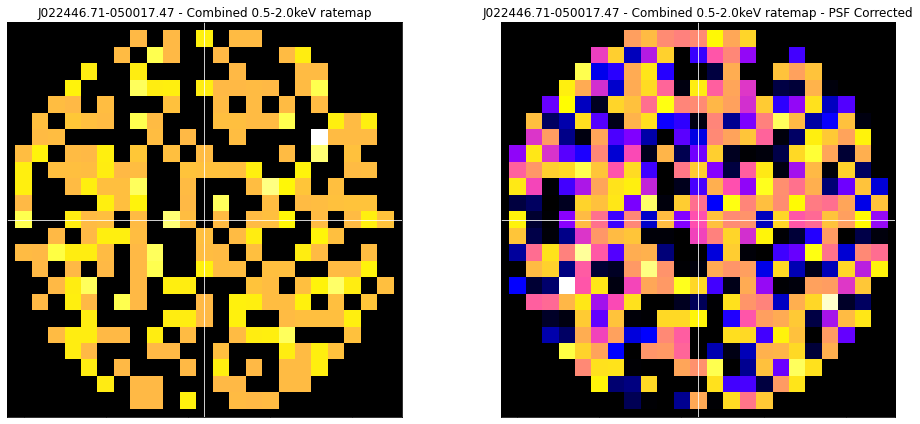

In [9]:
# Iterating through the sources that make up the sample
for src in srcs:
    # Sets up the two-column figure that the RateMaps are displayed in
    fig, ax_arr = plt.subplots(ncols=2, figsize=(14, 6))
    
    # Finding detection regions from the source object
    det_regs = [r for r in list(src._regions.values()) if r is not None]
    
    # Prints out whether the source has been detected or not, and the redshift
    if any(src.detected.values()):
        print('DETECTED,', "REDSHIFT={}".format(src.redshift))
    else:
        print('NOT DETECTED,', "REDSHIFT={}".format(src.redshift))
    
    # Setting up the custom mask, radius 50 arcseconds, interloper regions are NOT removed
    mask = src.get_custom_mask(Quantity(50, 'arcsec'), remove_interlopers=False)
    
    # Grabs the original 0.5-2.0keV combined ratemap from the current source
    rt = src.get_combined_ratemaps(lo_en=Quantity(0.5, 'keV'), hi_en=Quantity(2.0, 'keV'))
    
    # Retrieve the PSF corrected 0.5-2.0keV combined ratemap
    psf_rt = src.get_combined_ratemaps(psf_corr=True, psf_bins=8, lo_en=Quantity(0.5, 'keV'), 
                                       hi_en=Quantity(2.0, 'keV'))
    
    # If there are XCS regions that are considered to match the object, we add them to the RateMaps
    if len(det_regs) != 0:
        rt.regions = det_regs
        psf_rt.regions = det_regs
    
    # Using the get_view method of the ratemap, rather than view, as it will return the axis
    #  to be added to our two-column plot, rather than just displaying it
    cax = rt.get_view(ax_arr[0], src.ra_dec, mask, view_regions=True, zoom_in=True)
    
    # Again use the get_view method
    psf_rt.get_view(ax_arr[1], src.ra_dec, mask, view_regions=True, zoom_in=True)
    plt.tight_layout()
    plt.show()

## Running luminosity measurements

Here we run a simple absorbed power-law fit to the spectra of these sources. This function will generate all the necessary spectra within a 30 arcsecond aperture, with interloper sources masked out. We measure the unabsorbed bolometric (0.01-100 keV) and soft-band (0.5-2.0keV) luminosities, which are XGA defaults, and for now we also measure the unabsorbed 2.0-12.0keV luminosities as well.

This is entirely preliminary, as the current XGA (v0.2.2) spectral fitting procedure does not yet explicitly account for the possibility of X-ray variation when it simultaneously fits spectra. These results are not published, but will be better explored in a future study of X-ray variability of the sample. We set `redshifted` to False, meaning that a tbabs\*powerlaw model is fitted, rather than a tbabs\*\zpowerlw model.

In [10]:
# Define the energy bands in which to measure luminosity
lum_en = Quantity([[0.5, 2.], [0.01, 100], [2, 12]], 'keV')
# Run the power-law fit with XSPEC, will also generate any necessary spectra
power_law(srcs, 'point', redshifted=False, timeout=Quantity(24, 'h'), lum_en=lum_en)

Running XSPEC Fits: 100%|██████████| 11/11 [01:20<00:00,  7.35s/it]


## Retrieving preliminary luminosity values

Simply extracting the X-ray luminosity values from spectral fits, and displaying them for internal sanity checks. **These should not be considered as validated and safe for scientific use.** We also set the `quality_checks` argument to False, which returns luminosities that we wouldn't use for standard XGA analyses (their errors are too large, or negative, for instance):

In [11]:
lxs = srcs.Lx('point', 'constant*tbabs*powerlaw', lo_en=Quantity(2, 'keV'), hi_en=Quantity(12, 'keV'), 
              quality_checks=False)
print(lxs)

[[            nan             nan             nan]
 [ 1.98728377e+44  1.15387880e+44  9.34526714e+43]
 [ 2.89060752e+43  1.00920219e+43  1.46969825e+43]
 [ 2.17370484e+43  2.79787173e+42  4.32099107e+42]
 [            nan             nan             nan]
 [            nan             nan             nan]
 [ 2.93759519e+43  4.88174831e+42  9.65174953e+42]
 [ 2.39625906e+43  8.49207806e+42  1.16298945e+43]
 [ 1.71353874e+42  1.07267395e+42  2.49509065e+42]
 [ 6.16339192e+42  6.16339192e+42 -6.16339192e+42]
 [            nan             nan             nan]] erg / s


/home/dt237/code/PycharmProjects/XGA/xga/samples/base.py:249: UserWarning: There are no XSPEC fits associated with J033150.63-282910.86
  warn(str(err))
/home/dt237/code/PycharmProjects/XGA/xga/samples/base.py:249: UserWarning: There are no XSPEC fits associated with J033240.53-283622.28
  warn(str(err))
/home/dt237/code/PycharmProjects/XGA/xga/samples/base.py:249: UserWarning: There are no XSPEC fits associated with J032955.16-284359.67
  warn(str(err))
/home/dt237/code/PycharmProjects/XGA/xga/samples/base.py:249: UserWarning: There are no XSPEC fits associated with J022446.71-050017.47
  warn(str(err))
